In [1]:
# %%
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from shapely.geometry import Polygon, Point
import pyproj
import os
import ee
import geemap
import sys

# Add the src directory to the sys.path
sys.path.append(os.path.abspath('..'))

# Import functions from your secret_runway_detection package
from secret_runway_detection import train_utils, dataset

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Set random seed for reproducibility
import random
random.seed(train_utils.RANDOM_SEED)


In [2]:
# %%
# Define the path to the landing strips shapefile
landing_strips_shapefile = '../pac_2024_training/pac_2024_training.shp'

# Check if the shapefile exists
if not os.path.exists(landing_strips_shapefile):
    raise FileNotFoundError(f"Shapefile not found at {landing_strips_shapefile}")

# Read the landing strips shapefile
landing_strips = gpd.read_file(landing_strips_shapefile)

# Print the number of landing strips loaded
print(f"Number of landing strips loaded: {len(landing_strips)}")

# Display the first few rows
landing_strips.head()


Number of landing strips loaded: 154


,id,yr,largo,Activo,geometry
0,1,2023,968.918,0,"LINESTRING (-70.08929 -13.12984, -70.08053 -13..."
1,2,2022,1105.491,0,"LINESTRING (-69.16744 -13.62068, -69.17286 -13..."
2,3,2015,985.018,0,"LINESTRING (-69.14225 -13.69451, -69.14190 -13..."
3,4,2020,681.914,0,"LINESTRING (-69.07844 -13.78790, -69.08404 -13..."
4,5,2020,699.552,0,"LINESTRING (-69.07838 -13.78788, -69.08279 -13..."


In [3]:
# %%
# Define the number of tiles per side length for input areas
num_tiles_per_area_side_len = train_utils.TILES_PER_AREA_LEN  # Assuming this is defined in train_utils

# Generate input areas using the provided function
input_areas = train_utils.landing_strips_to_enclosing_input_areas(
    landing_strips=landing_strips,
    num_tiles_per_area_side_len=num_tiles_per_area_side_len
)

# Print the number of input areas generated
print(f"Number of input areas generated: {len(input_areas)}")

# Display the first few input areas
input_areas.head()


Total overlapping areas: 153
Number of input areas generated: 154


,geometry
0,"POLYGON ((-620.14354 -459.55052, 1379.85646 -4..."
1,"POLYGON ((-1853.52929 -187.49414, 146.47071 -1..."
2,"POLYGON ((-506.41802 -1024.40066, 1493.58198 -..."
3,"POLYGON ((-1368.85011 -1103.67224, 631.14989 -..."
4,"POLYGON ((-1687.94150 -26.78311, 312.05850 -26..."


In [4]:
# %%
# Select one input area to work with (e.g., the first one)
selected_input_area = input_areas.iloc[0]['geometry']

# Get the CRS of the input area
input_area_crs = input_areas.crs

# Generate the has_strip tensor for the selected input area
has_strip_tensor = train_utils.input_area_to_has_strip_tensor(
    landing_strips=landing_strips,
    input_area=selected_input_area,
    input_area_crs=input_area_crs,
    tiles_per_area_len=num_tiles_per_area_side_len
)

print(f"has_strip_tensor shape: {has_strip_tensor.shape}")

# Generate the satellite image for the selected input area
satellite_image = train_utils.input_area_to_input_image(
    input_area=selected_input_area,
    input_area_crs=input_area_crs
)

print(f"Satellite image shape: {satellite_image.shape}")


has_strip_tensor shape: torch.Size([200, 200])


/home/emil/Desktop/secret-runway-detection/.venv/lib/python3.12/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


KeyboardInterrupt: 

In [5]:
# inspect crs of landing strpts and input area
print(landing_strips.crs)
print(input_areas.crs)
print(input_area_crs)

# Reproject landing_strips to Web Mercator (EPSG:3857)
landing_strips = landing_strips.to_crs(epsg=3857)

# Reproject input_areas to Web Mercator (EPSG:3857)
input_areas = input_areas.to_crs(epsg=3857)

# Update the input_area_crs variable to the new CRS
input_area_crs = pyproj.CRS('EPSG:3857')

# Confirm the reprojection
print("Reprojected CRS:")
print(f"Landing Strips CRS: {landing_strips.crs}")
print(f"Input Areas CRS: {input_areas.crs}")
print(f"Input Area CRS Variable: {input_area_crs}")

# Display a sample of the reprojected data
print("\nSample Landing Strips:")
print(landing_strips.head())

print("\nSample Input Areas:")
print(input_areas.head())


EPSG:4326
EPSG:4326
EPSG:4326
Reprojected CRS:
Landing Strips CRS: EPSG:3857
Input Areas CRS: EPSG:3857
Input Area CRS Variable: EPSG:3857

Sample Landing Strips:
   id    yr     largo  Activo  \
0   1  2023   968.918       0   
1   2  2022  1105.491       0   
2   3  2015   985.018       0   
3   4  2020   681.914       0   
4   5  2020   699.552       0   

                                            geometry  
0  LINESTRING (-7802303.691 -1474570.543, -780132...  
1  LINESTRING (-7699684.464 -1530733.689, -770028...  
2  LINESTRING (-7696879.831 -1539191.640, -769684...  
3  LINESTRING (-7689776.357 -1549894.269, -769040...  
4  LINESTRING (-7689770.190 -1549892.213, -769026...  

Sample Input Areas:
                                            geometry
0  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...
1  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...
2  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...
3  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...
4  POLYGON ((inf inf, 

Error retrieving image data: Invalid JSON payload received. Unexpected token.
 {"constantValue": [Infinity, Infinity]}
                    ^
Satellite image (test) shape: (3, 224, 224)

Satellite Image Statistics:
Min value: 0.0
Max value: 0.0
Mean value: 0.0
Std deviation: 0.0


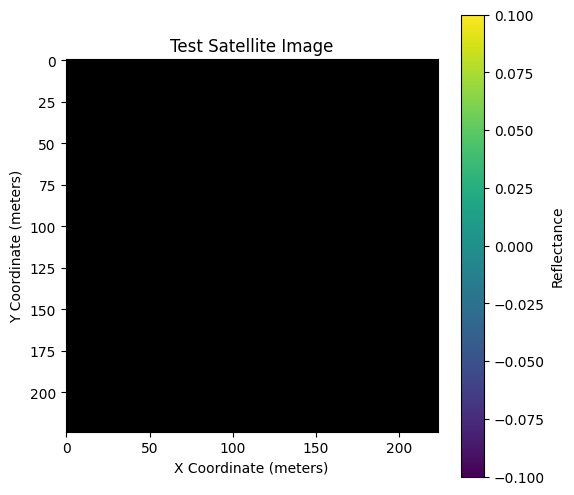

In [10]:
# %%
import matplotlib.pyplot as plt
from io import BytesIO

# Define desired image dimensions
INPUT_IMAGE_WIDTH = 224
INPUT_IMAGE_HEIGHT = 224

# Select the first input area from the reprojected GeoDataFrame
selected_input_area = input_areas.iloc[0]['geometry']

# Retrieve the satellite image for the selected input area
satellite_image_test = train_utils.input_area_to_input_image(
    input_area=selected_input_area,
    input_area_crs=input_area_crs,
    input_image_width=INPUT_IMAGE_WIDTH,
    input_image_height=INPUT_IMAGE_HEIGHT
)

print(f"Satellite image (test) shape: {satellite_image_test.shape}")

# Inspect statistics of the retrieved satellite image
print("\nSatellite Image Statistics:")
print(f"Min value: {satellite_image_test.min()}")
print(f"Max value: {satellite_image_test.max()}")
print(f"Mean value: {satellite_image_test.mean()}")
print(f"Std deviation: {satellite_image_test.std()}")

# Plot the retrieved satellite image
plt.figure(figsize=(6, 6))
# Transpose to (H, W, C) for plotting
satellite_image_rgb_test = np.transpose(satellite_image_test, (1, 2, 0))
# Clip values for display
satellite_image_rgb_test = np.clip(satellite_image_rgb_test, 0, 0.3)
plt.imshow(satellite_image_rgb_test)
plt.title('Test Satellite Image')
plt.xlabel('X Coordinate (meters)')
plt.ylabel('Y Coordinate (meters)')
plt.colorbar(label='Reflectance')
plt.show()


In [9]:
# %%
# Inspect statistics of the retrieved satellite image
print("Satellite Image Statistics:")
print(f"Min value: {satellite_image_test.min()}")
print(f"Max value: {satellite_image_test.max()}")
print(f"Mean value: {satellite_image_test.mean()}")
print(f"Std deviation: {satellite_image_test.std()}")

Satellite Image Statistics:
Min value: 0.0
Max value: 0.0
Mean value: 0.0
Std deviation: 0.0


/tmp/ipykernel_3700394/3495054764.py:38: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  landing_strips_in_area.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=2, label='Landing Strips')


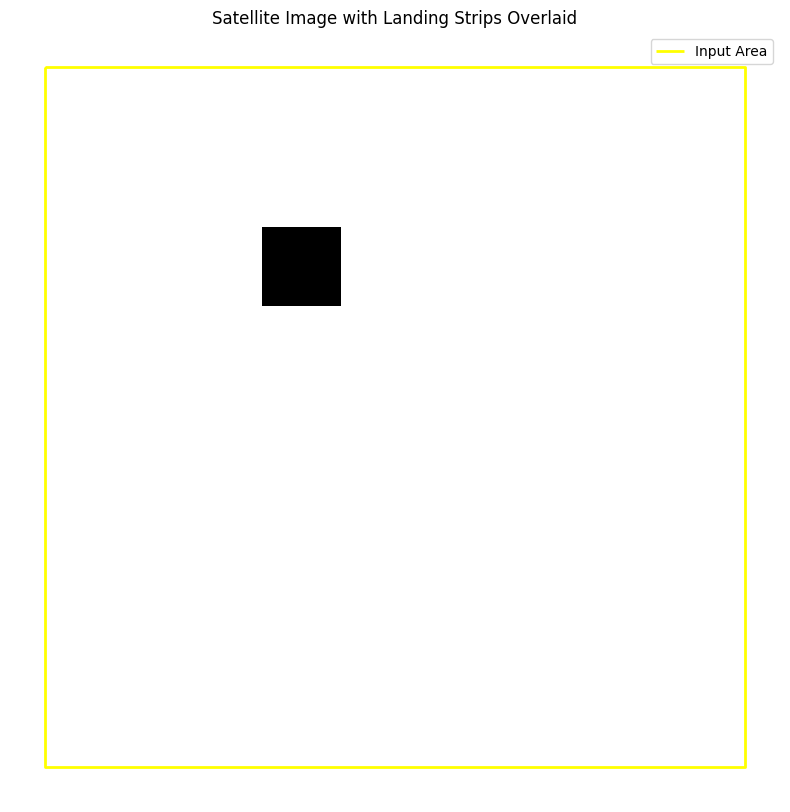

In [7]:
# %%
# %%
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pyproj

def plot_satellite_with_strips(
    satellite_image: np.ndarray, 
    input_area: Polygon, 
    landing_strips: gpd.GeoDataFrame, 
    crs: pyproj.CRS
):
    """
    Plots the satellite image with landing strips overlaid and displays coordinate axes.
    
    Parameters:
    - satellite_image (np.ndarray): Satellite image array with shape (C, H, W).
    - input_area (Polygon): The input area polygon.
    - landing_strips (gpd.GeoDataFrame): GeoDataFrame containing landing strip polygons.
    - crs (pyproj.CRS): Coordinate Reference System of the data.
    """
    # Convert satellite_image from (C, H, W) to (H, W, C) for plotting
    satellite_image_rgb = np.transpose(satellite_image, (1, 2, 0))
    
    # Normalize the image for display (assuming values are between 0 and 1)
    satellite_image_rgb = np.clip(satellite_image_rgb, 0, 0.3)  # Adjust max value based on your data
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define the extent based on the input area bounds
    minx, miny, maxx, maxy = input_area.bounds
    extent = [minx, maxx, miny, maxy]
    
    # Display the satellite image
    ax.imshow(satellite_image_rgb, extent=extent)
    
    # Create a GeoSeries for the input area
    input_area_gs = gpd.GeoSeries([input_area], crs=crs)
    
    # Plot the input area boundary
    input_area_gs.boundary.plot(edgecolor='yellow', linewidth=2, ax=ax, label='Input Area')
    
    # Plot the landing strips
    landing_strips.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Landing Strips')
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Add coordinate axes labels
    ax.set_xlabel('X Coordinate (meters)')
    ax.set_ylabel('Y Coordinate (meters)')
    
    # Set aspect ratio to 'equal' to maintain scale
    ax.set_aspect('equal', adjustable='box')
    
    # Show the plot
    plt.title('Satellite Image with Landing Strips Overlaid')
    plt.show()


# Plot the satellite image with landing strips overlaid
plot_satellite_with_strips(
    satellite_image=satellite_image,
    input_area=selected_input_area,
    landing_strips=landing_strips,
    crs=input_area_crs
)


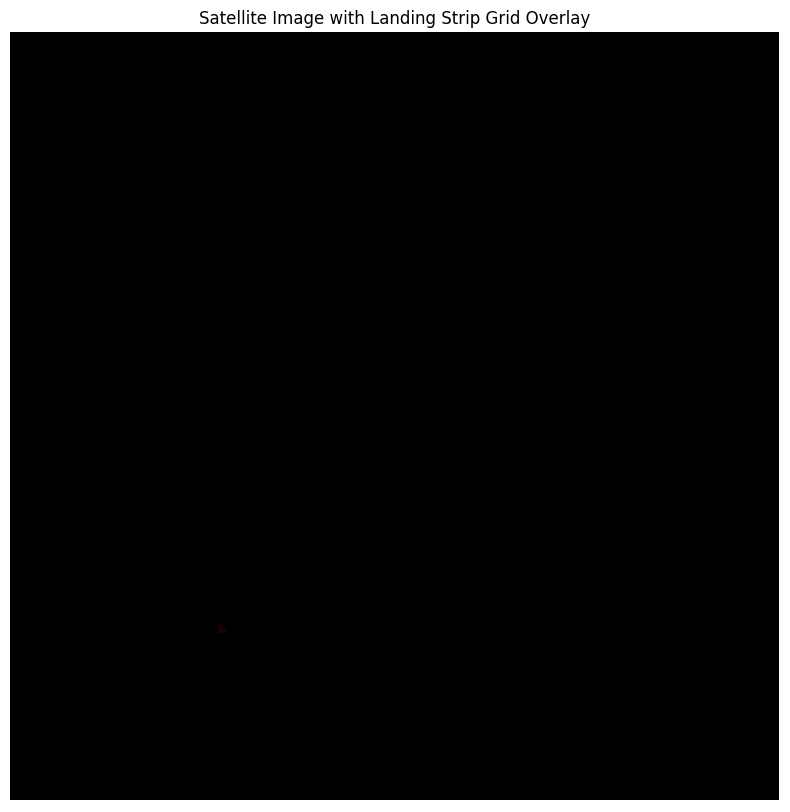

In [8]:
# %%
def plot_satellite_with_tensor_grid(satellite_image: np.ndarray, has_strip_tensor: torch.Tensor, tiles_per_area_len: int):
    """
    Plots the satellite image with a grid overlay indicating landing strip presence.

    Parameters:
    - satellite_image (np.ndarray): Satellite image array with shape (C, H, W).
    - has_strip_tensor (torch.Tensor): Tensor indicating landing strip presence in each tile.
    - tiles_per_area_len (int): Number of tiles per side.
    """
    # Convert satellite_image from (C, H, W) to (H, W, C) for plotting
    satellite_image_rgb = np.transpose(satellite_image, (1, 2, 0))
    
    # Normalize the image for display (assuming values are between 0 and 1)
    satellite_image_rgb = np.clip(satellite_image_rgb, 0, 1)
    
    # Create a figure
    plt.figure(figsize=(10, 10))
    
    # Display the satellite image
    plt.imshow(satellite_image_rgb)
    
    # Overlay the has_strip tensor
    has_strip_np = has_strip_tensor.numpy()
    
    # Create a color map where 0 is transparent and 1 is red with some transparency
    cmap = plt.cm.Reds
    cmap.set_under(color='none')  # Set color for values below the threshold (0)
    
    # Plot the tensor as a semi-transparent overlay
    plt.imshow(
        has_strip_np, 
        cmap=cmap, 
        alpha=0.3, 
        interpolation='nearest',
        extent=[0, satellite_image_rgb.shape[1], satellite_image_rgb.shape[0], 0],
        vmin=0.1  # Ensures that 0 values are transparent
    )
    
    # Remove axes
    plt.axis('off')
    
    # Add title
    plt.title('Satellite Image with Landing Strip Grid Overlay')
    
    # Show the plot
    plt.show()

# Plot the satellite image with has_strip tensor grid overlay
plot_satellite_with_tensor_grid(
    satellite_image=satellite_image,
    has_strip_tensor=has_strip_tensor,
    tiles_per_area_len=num_tiles_per_area_side_len
)
